In [17]:
import numpy as np


def smooth_filter(arr, size=5):
    """
    Apply a strict nanmean filter to a 2D array:
    - For each point, if more than one of the neighbors is NaN, return NaN.
    - Otherwise, return the nanmean of neighbors.
    
    Parameters:
        arr: 2D numpy array
        size: int, either 5 (cross-shaped) or 9 (3x3 square)
    
    Returns:
        2D numpy array with the filter applied.
    """
    arr = np.asarray(arr)
    if arr.ndim != 2:
        raise ValueError("Input array must be 2-dimensional.")
    if size not in (5, 9):
        raise ValueError("Size must be 5 or 9.")

    result = arr.copy()
    nrows, ncols = arr.shape

    for i in range(nrows):
        for j in range(ncols):
            if np.isnan(arr[i, j]):
                continue
            neighbors = []

            if size == 5:
                coords = [(i, j),
                          (i-1, j), (i+1, j),
                          (i, j-1), (i, j+1)]
            elif size == 9:
                coords = [(ii, jj)
                          for ii in range(i-1, i+2)
                          for jj in range(j-1, j+2)]

            for ii, jj in coords:
                if 0 <= ii < nrows and 0 <= jj < ncols:   #A way to deal with the borders
                    neighbors.append(arr[ii, jj])
                else:
                    neighbors.append(np.nan)

            if np.isnan(neighbors).sum() > 2:
                result[i, j] = np.nan
            else:
                result[i, j] = np.nanmean(neighbors)

    return result

In [ ]:
work_place = "ubuntu" # 'hydra', 'ubuntu' or 'win'
if work_place == 'hydra':
    base_path = r'/home/jorge.gacitua/salidas/L96_multiple_experiments/data/LETKF'
    output_dir = r'/home/jorge.gacitua/salidas/L96_multiple_experiments/figures'
elif work_place == 'ubuntu':
    base_path = r'/media/jgacitua/storage/L96_multiple_experiments/data/LETKF'
    output_dir = r'/media/jgacitua/storage/L96_multiple_experiments/figures'
elif work_place == 'win':
    base_path  = r'C:\Users\jyndd\OneDrive\Doctorado\Experimentos\L96_multiple_experiments\data\LETKF'
    output_dir = r'C:\Users\jyndd\OneDrive\Doctorado\Experimentos\L96_multiple_experiments\figures'

## Sensibilidad a GEC NO-GEC

NameError: name 'im' is not defined

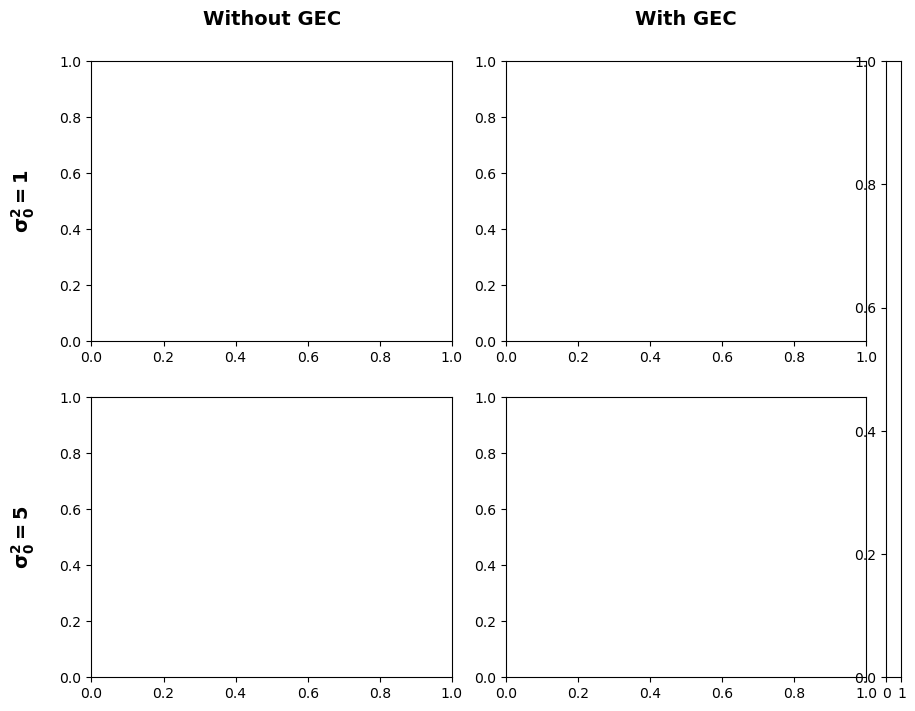

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import common_function as cf
import matplotlib.colors as mcolors
# Configuración
obs_errs = [ '1', '5']

labels = ['Without GEC', 'With GEC']


nens = 20
freq = 4
den = 1.0
alpha = 2
ntemp = 1
gecs = ['NOGEC', 'GEC']
fig, axes = plt.subplots(len(obs_errs), len(gecs), figsize=(10, 8), 
                         sharex=False, sharey=False, 
                         gridspec_kw={'hspace': 0.2, 'wspace': 0.15})

cbar_ax = fig.add_axes([0.92, 0.11, 0.015, 0.77])

vmin, vmax = 0, 2
panel_label_counter = 0

for i, obs in enumerate(obs_errs):
    for j, gec in enumerate(gecs):
        filename = f'LETKF_Paper_Nature_Freq{freq}_Den{den}_Type3_ObsErr{obs}_Nens{nens}_NTemp{ntemp}_alpha{alpha}_{gec}.npz'
        filepath = os.path.join(base_path, filename)
        ax = axes[i, j]

        if os.path.exists(filepath):
            data = np.load(filepath, allow_pickle=True)
            #results = data['results']
            mult_inf_range = data['mult_inf_range']
            loc_scale_range = data['loc_scale_range']
            #print(data['AlphaTempList'])
            total_analysis_rmse = data['total_analysis_rmse']

            NormalEnd = 1 - data['NormalEnd']
            NormalEnd = NormalEnd.astype(bool)
            total_analysis_rmse[NormalEnd] = np.nan
            total_analysis_rmse = cf.outlier_rmse_filter( total_analysis_rmse )

            min_rmse = np.nanmin(total_analysis_rmse)
            idx_min = np.where(total_analysis_rmse == min_rmse)
            best_mult_inf = mult_inf_range[idx_min[0][0]]
            best_loc_scale = loc_scale_range[idx_min[1][0]]

            total_analysis_rmse_smooth = smooth_filter(total_analysis_rmse, size=5)
            
            min_rmse_smooth = np.nanmin(total_analysis_rmse_smooth)
            idx_min_smooth = np.where(total_analysis_rmse_smooth == min_rmse_smooth)
            best_mult_inf_smooth = mult_inf_range[idx_min_smooth[0][0]]
            best_loc_scale_smooth = loc_scale_range[idx_min_smooth[1][0]]

            levels = np.arange(0, 2.1, 0.1)  # From 0 to 2, step 0.25
            norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

            im = ax.pcolormesh(mult_inf_range, loc_scale_range, total_analysis_rmse_smooth.T,
                            cmap='YlGn', norm=norm, edgecolors='lightgray', linewidth=0.001)            
            ax.plot(best_mult_inf, best_loc_scale, 'k.', markersize=12, markeredgecolor='white',markeredgewidth=0.5)
            ax.plot(best_mult_inf_smooth, best_loc_scale_smooth, 'w.', markersize=12, markeredgecolor='black',markeredgewidth=0.5)

            nan_mask = np.isnan(total_analysis_rmse_smooth.T)
            for (y, x), is_nan in np.ndenumerate(nan_mask):
                if is_nan:
                    xi = mult_inf_range[x]
                    yi = loc_scale_range[y]
                    ax.text(xi, yi, '×', ha='center', va='center', color='gray', fontsize=12, fontweight='bold')

            panel_label = rf"$\bf{{{chr(97 + panel_label_counter)}}}$"
            ax.set_title(f"({panel_label}) - Min. RMSE Raw={min_rmse:.2f} - Min. RMSE smooth={min_rmse_smooth:.2f}", fontsize=9)
            panel_label_counter += 1

            if j == 0:
                ax.set_ylabel('Localization Scale', fontsize=10)
            if i == len(obs_errs) - 1:
                ax.set_xlabel('Multiplicative Inflation', fontsize=10)

for i, obs in enumerate(obs_errs):
    axes[i, 0].annotate(rf"$\bf{{\sigma^2_0 = {obs}}}$", xy=(-0.15, 0.5), xycoords='axes fraction',
                        rotation=90, va='center', ha='right', fontsize=14, weight='bold')
for j, t in enumerate(gecs):
    axes[0, j].annotate(labels[j], xy=(0.5, 1.15), xycoords='axes fraction',
                        va='center', ha='center', fontsize=14, weight='bold')
cbar = fig.colorbar(im, cax=cbar_ax,ticks=np.arange(0, 2.2, 0.2))
cbar.set_label('Total Analysis RMSE', fontsize=14)

os.makedirs(output_dir, exist_ok=True)
figname = f"Compare_GEC_NOGEC_LETKF_Alpha{alpha}_Den{den}_Nens{nens}_Freq{freq}_NTemp{ntemp}_smooth"
output_pdf = os.path.join(output_dir, f"{figname}.pdf")
output_png = os.path.join(output_dir, f"{figname}.png")

plt.savefig(output_pdf, dpi=300, bbox_inches='tight', format='pdf')
plt.savefig(output_png, dpi=300, bbox_inches='tight', format='png')
plt.show()

print(f"Figure saved as: \n PDF: {output_pdf} \n PNG: {output_png}")

## Compare Smooth

Figure saved as: 
 PDF: C:\Users\jyndd\OneDrive\Doctorado\Experimentos\L96_multiple_experiments\figures\Figure_compare_smooth_noSmooth_Nens20_Freq4_Den1.0_Type3_PTemp2_NOGEC_smooth.pdf 
 PNG: C:\Users\jyndd\OneDrive\Doctorado\Experimentos\L96_multiple_experiments\figures\Figure_compare_smooth_noSmooth_Nens20_Freq4_Den1.0_Type3_PTemp2_NOGEC_smooth.png


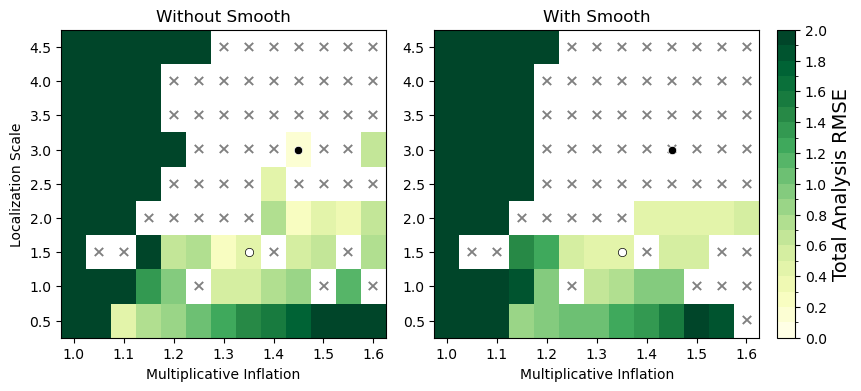

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import common_function as cf
import matplotlib.colors as mcolors
# Configuración
obs_errs = ['0.3', '1', '5', '25']
ntemps = [1, 2, 3]
labels = ['LETKF', 'LETKF-T2', 'LETKF-T3']

nens = 20
freq = 4
den = 1.0
alpha = 2
gec = '_NOGEC'
fig, axes = plt.subplots(1, 2, figsize=(9, 4), 
                         sharex=False, sharey=False, 
                         gridspec_kw={'hspace': 0.3, 'wspace': 0.15})


cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])  # x, y, width, height

vmin, vmax = 0, 2
panel_label_counter = 0
obs = '0.3'  # Default observation error for the first plot
ntemp = 2

filename = f'LETKF_Paper_Nature_Freq{freq}_Den{den}_Type3_ObsErr{obs}_Nens{nens}_NTemp{ntemp}_alpha{alpha}{gec}.npz'
filepath = os.path.join(base_path, filename)



if os.path.exists(filepath):
    data = np.load(filepath, allow_pickle=True)
    #results = data['results']
    mult_inf_range = data['mult_inf_range']
    loc_scale_range = data['loc_scale_range']
    #print(data['AlphaTempList'])
    total_analysis_rmse = data['total_analysis_rmse']

    NormalEnd = 1 - data['NormalEnd']
    NormalEnd = NormalEnd.astype(bool)
    total_analysis_rmse[NormalEnd] = np.nan
    total_analysis_rmse = cf.outlier_rmse_filter( total_analysis_rmse )

    min_rmse = np.nanmin(total_analysis_rmse)
    idx_min = np.where(total_analysis_rmse == min_rmse)
    best_mult_inf = mult_inf_range[idx_min[0][0]]
    best_loc_scale = loc_scale_range[idx_min[1][0]]

    total_analysis_rmse_smooth = smooth_filter(total_analysis_rmse, size=5)
    
    min_rmse_smooth = np.nanmin(total_analysis_rmse_smooth)
    idx_min_smooth = np.where(total_analysis_rmse_smooth == min_rmse_smooth)
    best_mult_inf_smooth = mult_inf_range[idx_min_smooth[0][0]]
    best_loc_scale_smooth = loc_scale_range[idx_min_smooth[1][0]]

    #im = ax.pcolormesh(mult_inf_range, loc_scale_range, total_analysis_rmse.T, 
    #                    vmin=vmin, vmax=vmax, cmap='PuBu',edgecolors='lightgray',linewidth=0.001)
    levels = np.arange(0, 2.1, 0.1)  # From 0 to 2, step 0.25
    norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

    im1 = axes[0].pcolormesh(mult_inf_range, loc_scale_range, total_analysis_rmse.T,
                             cmap='YlGn', norm=norm, edgecolors='lightgray', linewidth=0.001)  
    im2 = axes[1].pcolormesh(mult_inf_range, loc_scale_range, total_analysis_rmse_smooth.T,
                            cmap='YlGn', norm=norm, edgecolors='lightgray', linewidth=0.001)            


    nan_mask_smooth = np.isnan(total_analysis_rmse_smooth.T)
    for (y, x), is_nan in np.ndenumerate(nan_mask_smooth):
        if is_nan:
            xi = mult_inf_range[x]
            yi = loc_scale_range[y]
            axes[1].text(xi, yi, '×', ha='center', va='center', color='gray', fontsize=12, fontweight='bold')

    nan_mask = np.isnan(total_analysis_rmse.T)
    for (y, x), is_nan in np.ndenumerate(nan_mask):
        if is_nan:
            xi = mult_inf_range[x]
            yi = loc_scale_range[y]
            axes[0].text(xi, yi, '×', ha='center', va='center', color='gray', fontsize=12, fontweight='bold')

    axes[0].plot(best_mult_inf, best_loc_scale, 'k.', markersize=12, markeredgecolor='white',markeredgewidth=0.5,zorder=5)
    axes[0].plot(best_mult_inf_smooth, best_loc_scale_smooth, 'w.', markersize=12, markeredgecolor='black',markeredgewidth=0.5,zorder=5)

    axes[1].plot(best_mult_inf, best_loc_scale, 'k.', markersize=12, markeredgecolor='white',markeredgewidth=0.5,zorder=5)
    axes[1].plot(best_mult_inf_smooth, best_loc_scale_smooth, 'w.', markersize=12, markeredgecolor='black',markeredgewidth=0.5,zorder=5)

    panel_label = rf"$\bf{{{chr(97 + panel_label_counter)}}}$"
    axes[0].set_title(f"(Min. RMSE={min_rmse:.2f}", fontsize=11)
    axes[1].set_title(f"(Min. RMSE={min_rmse_smooth:.2f}", fontsize=11)

    axes[0].set_title('Without Smooth', fontsize=12)
    axes[1].set_title('With Smooth', fontsize=12)
    axes[0].set_ylabel('Localization Scale', fontsize=10)
    axes[0].set_xlabel('Multiplicative Inflation', fontsize=10)
    axes[1].set_xlabel('Multiplicative Inflation', fontsize=10)


cbar = fig.colorbar(im1, cax=cbar_ax,ticks=np.arange(0, 2.2, 0.2))
cbar.set_label('Total Analysis RMSE', fontsize=14)

os.makedirs(output_dir, exist_ok=True)
figname = f"Figure_compare_smooth_noSmooth_Nens{nens}_Freq{freq}_Den{den}_Type3_PTemp{alpha}{gec}_smooth"
output_pdf = os.path.join(output_dir, f"{figname}.pdf")
output_png = os.path.join(output_dir, f"{figname}.png")

plt.savefig(output_pdf, dpi=300, bbox_inches='tight', format='pdf')
plt.savefig(output_png, dpi=300, bbox_inches='tight', format='png')
#plt.show()

print(f"Figure saved as: \n PDF: {output_pdf} \n PNG: {output_png}")

## Sensibilidad al Error en las Observaciones

Figure saved as: 
 PDF: C:\Users\jyndd\OneDrive\Doctorado\Experimentos\L96_multiple_experiments\figures\Figure_ObsError_Sensitivity_Nens20_Freq4_Den1.0_Type3_PTemp2_NOGEC_smooth.pdf 
 PNG: C:\Users\jyndd\OneDrive\Doctorado\Experimentos\L96_multiple_experiments\figures\Figure_ObsError_Sensitivity_Nens20_Freq4_Den1.0_Type3_PTemp2_NOGEC_smooth.png


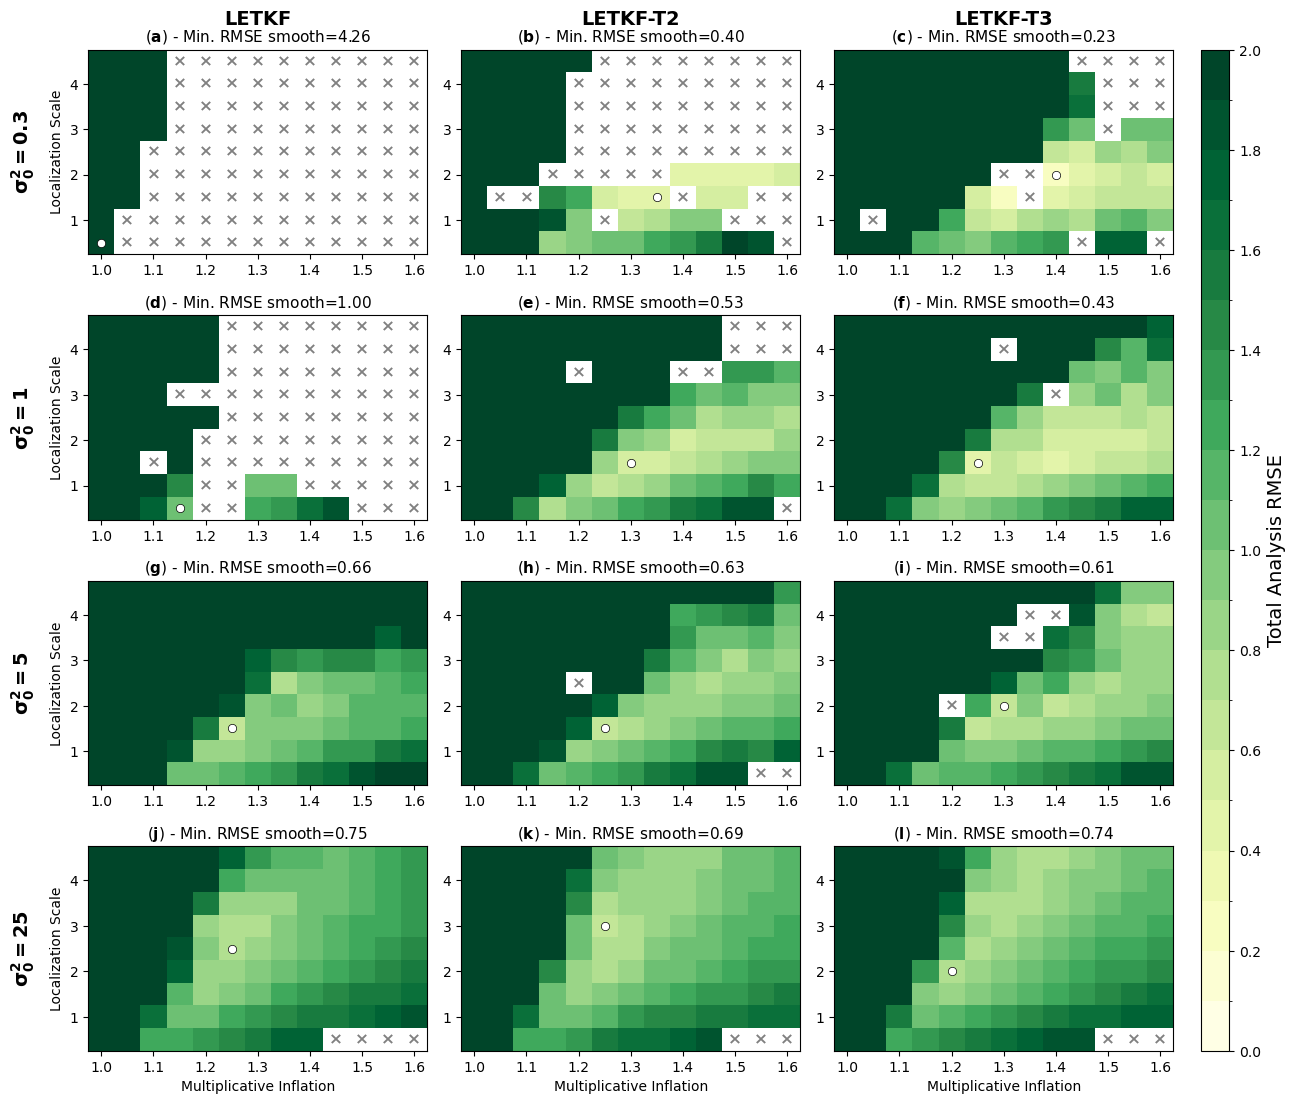

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import common_function as cf
import matplotlib.colors as mcolors
# Configuración
obs_errs = ['0.3', '1', '5', '25']
ntemps = [1, 2, 3]
labels = ['LETKF', 'LETKF-T2', 'LETKF-T3']

nens = 20
freq = 4
den = 1.0
alpha = 2
gec = '_NOGEC'
fig, axes = plt.subplots(len(obs_errs), len(ntemps), figsize=(14, 13), 
                         sharex=False, sharey=False, 
                         gridspec_kw={'hspace': 0.3, 'wspace': 0.1})


cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])  # x, y, width, height

vmin, vmax = 0, 2
panel_label_counter = 0

for i, obs in enumerate(obs_errs):
    for j, ntemp in enumerate(ntemps):
        #filename = f'ORIG_LETKF_Paper_Nature_Freq{freq}_Den{den}_Type3_ObsErr{obs}_Nens20_NTemp{ntemp}{gec}.npz'
        filename = f'LETKF_Paper_Nature_Freq{freq}_Den{den}_Type3_ObsErr{obs}_Nens{nens}_NTemp{ntemp}_alpha{alpha}{gec}.npz'
        filepath = os.path.join(base_path, filename)

        ax = axes[i, j]

        if os.path.exists(filepath):
            data = np.load(filepath, allow_pickle=True)
            #results = data['results']
            mult_inf_range = data['mult_inf_range']
            loc_scale_range = data['loc_scale_range']
            #print(data['AlphaTempList'])
            total_analysis_rmse = data['total_analysis_rmse']

            NormalEnd = 1 - data['NormalEnd']
            NormalEnd = NormalEnd.astype(bool)
            total_analysis_rmse[NormalEnd] = np.nan
            total_analysis_rmse = cf.outlier_rmse_filter( total_analysis_rmse )

            min_rmse = np.nanmin(total_analysis_rmse)
            idx_min = np.where(total_analysis_rmse == min_rmse)
            best_mult_inf = mult_inf_range[idx_min[0][0]]
            best_loc_scale = loc_scale_range[idx_min[1][0]]

            total_analysis_rmse_smooth = smooth_filter(total_analysis_rmse, size=5)
            
            min_rmse_smooth = np.nanmin(total_analysis_rmse_smooth)
            idx_min_smooth = np.where(total_analysis_rmse_smooth == min_rmse_smooth)
            best_mult_inf_smooth = mult_inf_range[idx_min_smooth[0][0]]
            best_loc_scale_smooth = loc_scale_range[idx_min_smooth[1][0]]

            #im = ax.pcolormesh(mult_inf_range, loc_scale_range, total_analysis_rmse.T, 
            #                    vmin=vmin, vmax=vmax, cmap='PuBu',edgecolors='lightgray',linewidth=0.001)
            levels = np.arange(0, 2.1, 0.1)  # From 0 to 2, step 0.25
            norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

            im = ax.pcolormesh(mult_inf_range, loc_scale_range, total_analysis_rmse_smooth.T,
                            cmap='YlGn', norm=norm, edgecolors='lightgray', linewidth=0.001)            
            #ax.plot(best_mult_inf, best_loc_scale, 'k.', markersize=12, markeredgecolor='white',markeredgewidth=0.5)
            ax.plot(best_mult_inf_smooth, best_loc_scale_smooth, 'w.', markersize=12, markeredgecolor='black',markeredgewidth=0.5)

            nan_mask = np.isnan(total_analysis_rmse_smooth.T)
            for (y, x), is_nan in np.ndenumerate(nan_mask):
                if is_nan:
                    xi = mult_inf_range[x]
                    yi = loc_scale_range[y]
                    ax.text(xi, yi, '×', ha='center', va='center', color='gray', fontsize=12, fontweight='bold')

            panel_label = rf"$\bf{{{chr(97 + panel_label_counter)}}}$"
            ax.set_title(f"({panel_label}) - Min. RMSE smooth={min_rmse_smooth:.2f}", fontsize=11)

            panel_label_counter += 1

            if j == 0:
                ax.set_ylabel('Localization Scale', fontsize=10)
            if i == len(obs_errs) - 1:
                ax.set_xlabel('Multiplicative Inflation', fontsize=10)

for i, obs in enumerate(obs_errs):
    axes[i, 0].annotate(rf"$\bf{{\sigma^2_0 = {obs}}}$", xy=(-0.15, 0.5), xycoords='axes fraction',
                        rotation=90, va='center', ha='right', fontsize=14, weight='bold')
for j, t in enumerate(ntemps):
    axes[0, j].annotate(labels[j], xy=(0.5, 1.15), xycoords='axes fraction',
                        va='center', ha='center', fontsize=14, weight='bold')
cbar = fig.colorbar(im, cax=cbar_ax,ticks=np.arange(0, 2.2, 0.2))
cbar.set_label('Total Analysis RMSE', fontsize=14)

os.makedirs(output_dir, exist_ok=True)
figname = f"Figure_ObsError_Sensitivity_Nens{nens}_Freq{freq}_Den{den}_Type3_PTemp{alpha}{gec}_smooth"
output_pdf = os.path.join(output_dir, f"{figname}.pdf")
output_png = os.path.join(output_dir, f"{figname}.png")

plt.savefig(output_pdf, dpi=300, bbox_inches='tight', format='pdf')
plt.savefig(output_png, dpi=300, bbox_inches='tight', format='png')
#plt.show()

print(f"Figure saved as: \n PDF: {output_pdf} \n PNG: {output_png}")

Figure saved as: 
 PDF: C:\Users\jyndd\OneDrive\Doctorado\Experimentos\L96_multiple_experiments\figures\Figure_ObsError_Sensitivity_Nens20_Freq4_Den1.0_Type3_PTemp2_NOGEC_WIDE_smooth.pdf 
 PNG: C:\Users\jyndd\OneDrive\Doctorado\Experimentos\L96_multiple_experiments\figures\Figure_ObsError_Sensitivity_Nens20_Freq4_Den1.0_Type3_PTemp2_NOGEC_WIDE_smooth.png


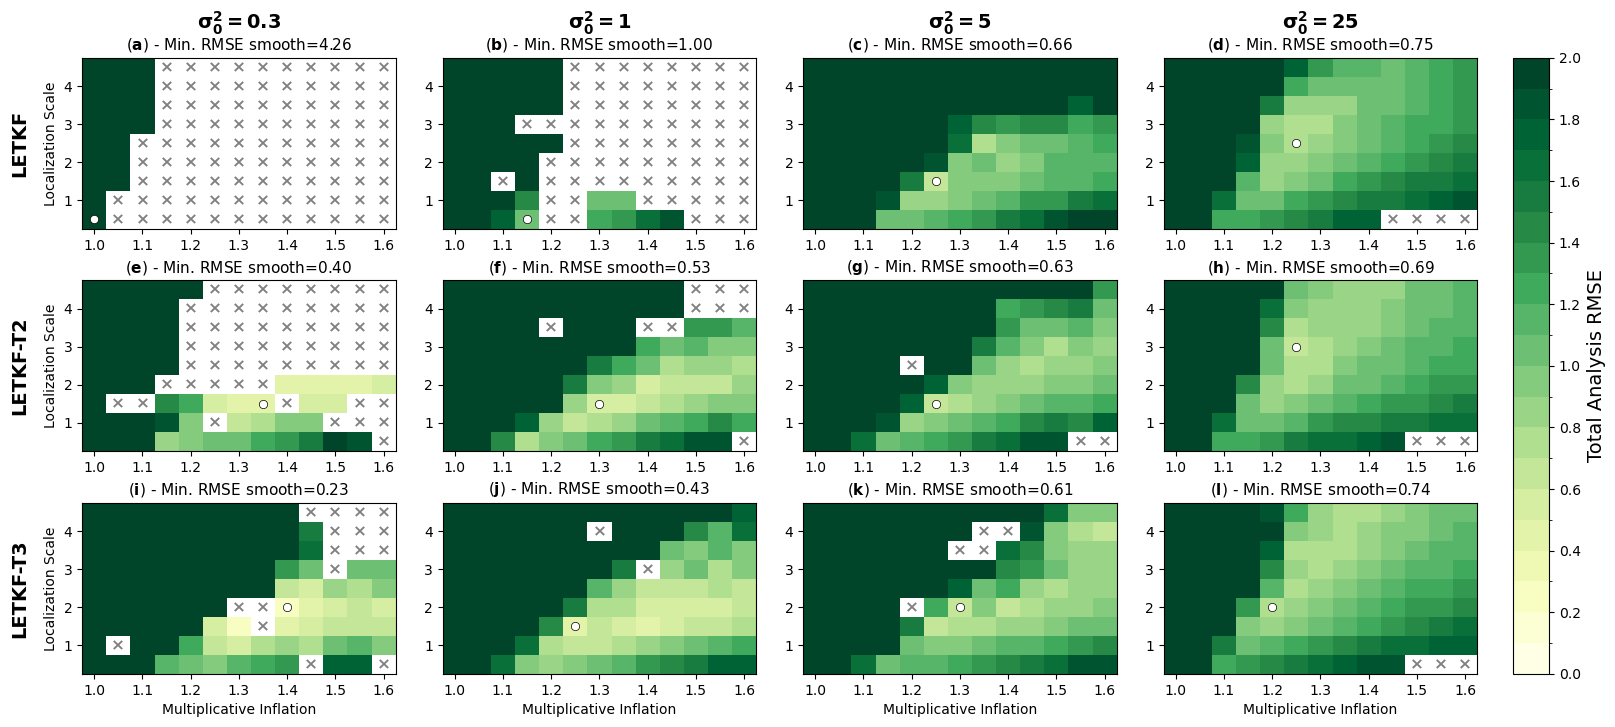

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import common_function as cf
import matplotlib.colors as mcolors
# Configuración
obs_errs = ['0.3', '1', '5', '25']
ntemps = [1, 2, 3]
labels = ['LETKF', 'LETKF-T2', 'LETKF-T3']

nens = 20
freq = 4
den = 1.0
alpha = 2
gec = '_NOGEC'
fig, axes = plt.subplots(len(ntemps), len(obs_errs), figsize=(18, 8),  # Wider layout
                         sharex=False, sharey=False, 
                         gridspec_kw={'hspace': 0.3, 'wspace': 0.15})

cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])  # x, y, width, height

vmin, vmax = 0, 2
panel_label_counter = 0

for j, ntemp in enumerate(ntemps):
    for i, obs in enumerate(obs_errs):
        filename = f'LETKF_Paper_Nature_Freq{freq}_Den{den}_Type3_ObsErr{obs}_Nens{nens}_NTemp{ntemp}_alpha{alpha}{gec}.npz'
        filepath = os.path.join(base_path, filename)

        ax = axes[j, i]

        if os.path.exists(filepath):
            data = np.load(filepath, allow_pickle=True)
            mult_inf_range = data['mult_inf_range']
            loc_scale_range = data['loc_scale_range']
            total_analysis_rmse = data['total_analysis_rmse']

            NormalEnd = 1 - data['NormalEnd']
            NormalEnd = NormalEnd.astype(bool)
            total_analysis_rmse[NormalEnd] = np.nan
            total_analysis_rmse = cf.outlier_rmse_filter( total_analysis_rmse )

            min_rmse = np.nanmin(total_analysis_rmse)
            idx_min = np.where(total_analysis_rmse == min_rmse)
            best_mult_inf = mult_inf_range[idx_min[0][0]]
            best_loc_scale = loc_scale_range[idx_min[1][0]]

            total_analysis_rmse_smooth = smooth_filter(total_analysis_rmse, size=5)
            
            min_rmse_smooth = np.nanmin(total_analysis_rmse_smooth)
            idx_min_smooth = np.where(total_analysis_rmse_smooth == min_rmse_smooth)
            best_mult_inf_smooth = mult_inf_range[idx_min_smooth[0][0]]
            best_loc_scale_smooth = loc_scale_range[idx_min_smooth[1][0]]

            #im = ax.pcolormesh(mult_inf_range, loc_scale_range, total_analysis_rmse.T, 
            #                    vmin=vmin, vmax=vmax, cmap='PuBu',edgecolors='lightgray',linewidth=0.001)
            levels = np.arange(0, 2.1, 0.1)  # From 0 to 2, step 0.25
            norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

            im = ax.pcolormesh(mult_inf_range, loc_scale_range, total_analysis_rmse_smooth.T,
                            cmap='YlGn', norm=norm, edgecolors='lightgray', linewidth=0.001)            
            #ax.plot(best_mult_inf, best_loc_scale, 'k.', markersize=12, markeredgecolor='white',markeredgewidth=0.5)
            ax.plot(best_mult_inf_smooth, best_loc_scale_smooth, 'w.', markersize=12, markeredgecolor='black',markeredgewidth=0.5)

            nan_mask = np.isnan(total_analysis_rmse_smooth.T)
            for (y, x), is_nan in np.ndenumerate(nan_mask):
                if is_nan:
                    xi = mult_inf_range[x]
                    yi = loc_scale_range[y]
                    ax.text(xi, yi, '×', ha='center', va='center', color='gray', fontsize=12, fontweight='bold')

            panel_label = rf"$\bf{{{chr(97 + panel_label_counter)}}}$"
            ax.set_title(f"({panel_label}) - Min. RMSE smooth={min_rmse_smooth:.2f}", fontsize=11)
            panel_label_counter += 1

            if i == 0:
                ax.set_ylabel('Localization Scale', fontsize=10)
            if j == len(ntemps) - 1:
                ax.set_xlabel('Multiplicative Inflation', fontsize=10)

# Column headers (σ²₀ labels)
for i, obs in enumerate(obs_errs):
    axes[0, i].annotate(rf"$\bf{{\sigma^2_0 = {obs}}}$", xy=(0.5, 1.12), xycoords='axes fraction',
                        va='bottom', ha='center', fontsize=14, weight='bold')

# Row labels (LETKF versions)
for j, label in enumerate(labels):
    axes[j, 0].annotate(label, xy=(-0.2, 0.5), xycoords='axes fraction',
                        rotation=90, va='center', ha='center', fontsize=14, weight='bold')

cbar = fig.colorbar(im, cax=cbar_ax,ticks=np.arange(0, 2.2, 0.2))
cbar.set_label('Total Analysis RMSE', fontsize=14)

os.makedirs(output_dir, exist_ok=True)
figname = f"Figure_ObsError_Sensitivity_Nens{nens}_Freq{freq}_Den{den}_Type3_PTemp{alpha}{gec}_WIDE_smooth"
output_pdf = os.path.join(output_dir, f"{figname}.pdf")
output_png = os.path.join(output_dir, f"{figname}.png")

plt.savefig(output_pdf, dpi=300, bbox_inches='tight', format='pdf')
plt.savefig(output_png, dpi=300, bbox_inches='tight', format='png')

print(f"Figure saved as: \n PDF: {output_pdf} \n PNG: {output_png}")



### Sensibilidad al numero de Ensambles

Figure saved as: 
 PDF: C:\Users\jyndd\OneDrive\Doctorado\Experimentos\L96_multiple_experiments\figures\Figure_Nens_Sensitivity_Freq4_Den1.0_Type3_PTemp2_ObsErr5_NOGEC_smooth.pdf 
 PNG: C:\Users\jyndd\OneDrive\Doctorado\Experimentos\L96_multiple_experiments\figures\Figure_Nens_Sensitivity_Freq4_Den1.0_Type3_PTemp2_ObsErr5_NOGEC_smooth.png


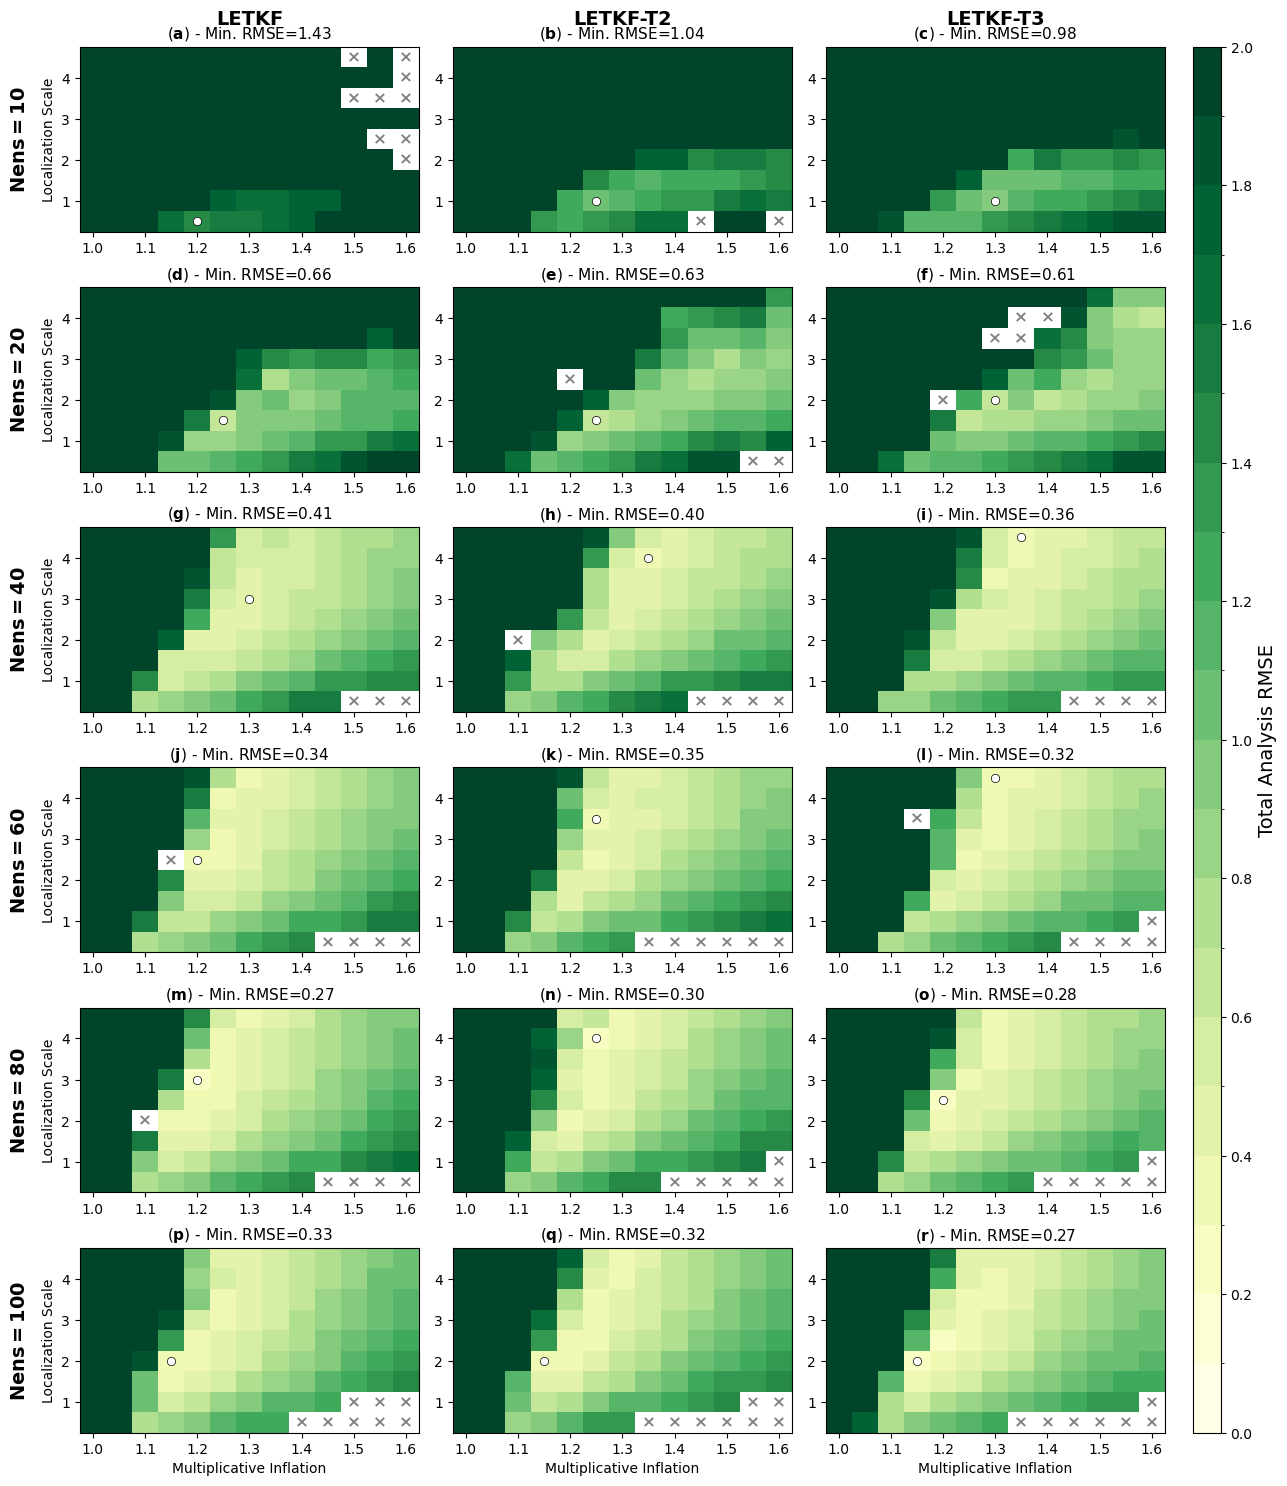

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import common_function as cf
import matplotlib.colors as mcolors
# Configuración
ntemps = [1, 2, 3]
labels = ['LETKF', 'LETKF-T2', 'LETKF-T3']
nens = [10, 20, 40, 60, 80, 100]

freq = 4
den = 1.0
alpha = 2
ObseErr = '5'
gec = 'NOGEC'
fig, axes = plt.subplots(len(nens), len(ntemps), figsize=(14, 18), 
                         sharex=False, sharey=False, 
                         gridspec_kw={'hspace': 0.3, 'wspace': 0.1})


cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])  # x, y, width, height

vmin, vmax = 0, 2
panel_label_counter = 0

for i, nen in enumerate(nens):
    for j, ntemp in enumerate(ntemps):
        filename = f'LETKF_Paper_Nature_Freq{freq}_Den{den}_Type3_ObsErr{ObseErr}_Nens{nen}_NTemp{ntemp}_alpha{alpha}_{gec}.npz'
        filepath = os.path.join(base_path, filename)
        #print(filepath)

        if os.path.exists(filepath):
            data = np.load(filepath, allow_pickle=True)
            #results = data['results']
            mult_inf_range = data['mult_inf_range']
            loc_scale_range = data['loc_scale_range']

            ax = axes[i, j]
            total_analysis_rmse = data['total_analysis_rmse']
            NormalEnd = 1 - data['NormalEnd']
            NormalEnd = NormalEnd.astype(bool)
            total_analysis_rmse[NormalEnd] = np.nan
            total_analysis_rmse = cf.outlier_rmse_filter( total_analysis_rmse )

            min_rmse = np.nanmin(total_analysis_rmse)
            idx_min = np.where(total_analysis_rmse == min_rmse)
            best_mult_inf = mult_inf_range[idx_min[0][0]]
            best_loc_scale = loc_scale_range[idx_min[1][0]]

            total_analysis_rmse_smooth = smooth_filter(total_analysis_rmse, size=5)
            
            min_rmse_smooth = np.nanmin(total_analysis_rmse_smooth)
            idx_min_smooth = np.where(total_analysis_rmse_smooth == min_rmse_smooth)
            best_mult_inf_smooth = mult_inf_range[idx_min_smooth[0][0]]
            best_loc_scale_smooth = loc_scale_range[idx_min_smooth[1][0]]

            #im = ax.pcolormesh(mult_inf_range, loc_scale_range, total_analysis_rmse.T, 
            #                    vmin=vmin, vmax=vmax, cmap='PuBu',edgecolors='lightgray',linewidth=0.001)
            levels = np.arange(0, 2.1, 0.1)  # From 0 to 2, step 0.25
            norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

            im = ax.pcolormesh(mult_inf_range, loc_scale_range, total_analysis_rmse_smooth.T,
                            cmap='YlGn', norm=norm, edgecolors='lightgray', linewidth=0.001)            
            #ax.plot(best_mult_inf, best_loc_scale, 'k.', markersize=12, markeredgecolor='white',markeredgewidth=0.5)
            ax.plot(best_mult_inf_smooth, best_loc_scale_smooth, 'w.', markersize=12, markeredgecolor='black',markeredgewidth=0.5)

            nan_mask = np.isnan(total_analysis_rmse_smooth.T)
            for (y, x), is_nan in np.ndenumerate(nan_mask):
                if is_nan:
                    xi = mult_inf_range[x]
                    yi = loc_scale_range[y]
                    ax.text(xi, yi, '×', ha='center', va='center', color='gray', fontsize=12, fontweight='bold')

            panel_label = rf"$\bf{{{chr(97 + panel_label_counter)}}}$"
            ax.set_title(f"({panel_label}) - Min. RMSE={min_rmse_smooth:.2f}", fontsize=11)
            panel_label_counter += 1

            if j == 0:
                ax.set_ylabel('Localization Scale', fontsize=10)
            if i == len(nens) - 1:
                ax.set_xlabel('Multiplicative Inflation', fontsize=10)

for i, nen in enumerate(nens):
    axes[i, 0].annotate(rf"$\bf{{Nens = {nen}}}$", xy=(-0.15, 0.5), xycoords='axes fraction',
                        rotation=90, va='center', ha='right', fontsize=14, weight='bold')
for j, t in enumerate(ntemps):
    axes[0, j].annotate(labels[j], xy=(0.5, 1.15), xycoords='axes fraction',
                        va='center', ha='center', fontsize=14, weight='bold')
cbar = fig.colorbar(im, cax=cbar_ax,ticks=np.arange(0, 2.2, 0.2))
cbar.set_label('Total Analysis RMSE', fontsize=14)

os.makedirs(output_dir, exist_ok=True)
figname = f"Figure_Nens_Sensitivity_Freq{freq}_Den{den}_Type3_PTemp{alpha}_ObsErr{ObseErr}_{gec}_smooth"
output_pdf = os.path.join(output_dir, f"{figname}.pdf")
output_png = os.path.join(output_dir, f"{figname}.png")

plt.savefig(output_pdf, dpi=300, bbox_inches='tight', format='pdf')
plt.savefig(output_png, dpi=300, bbox_inches='tight', format='png')
#plt.show()

print(f"Figure saved as: \n PDF: {output_pdf} \n PNG: {output_png}")

Figure saved as: 
 PDF: C:\Users\jyndd\OneDrive\Doctorado\Experimentos\L96_multiple_experiments\figures\Figure_Alpha_Sensitivity_Freq4_Den1.0_Type3_nens80_ObsErr5_NOGEC_smooth.pdf 
 PNG: C:\Users\jyndd\OneDrive\Doctorado\Experimentos\L96_multiple_experiments\figures\Figure_Alpha_Sensitivity_Freq4_Den1.0_Type3_nens80_ObsErr5_NOGEC_smooth.png


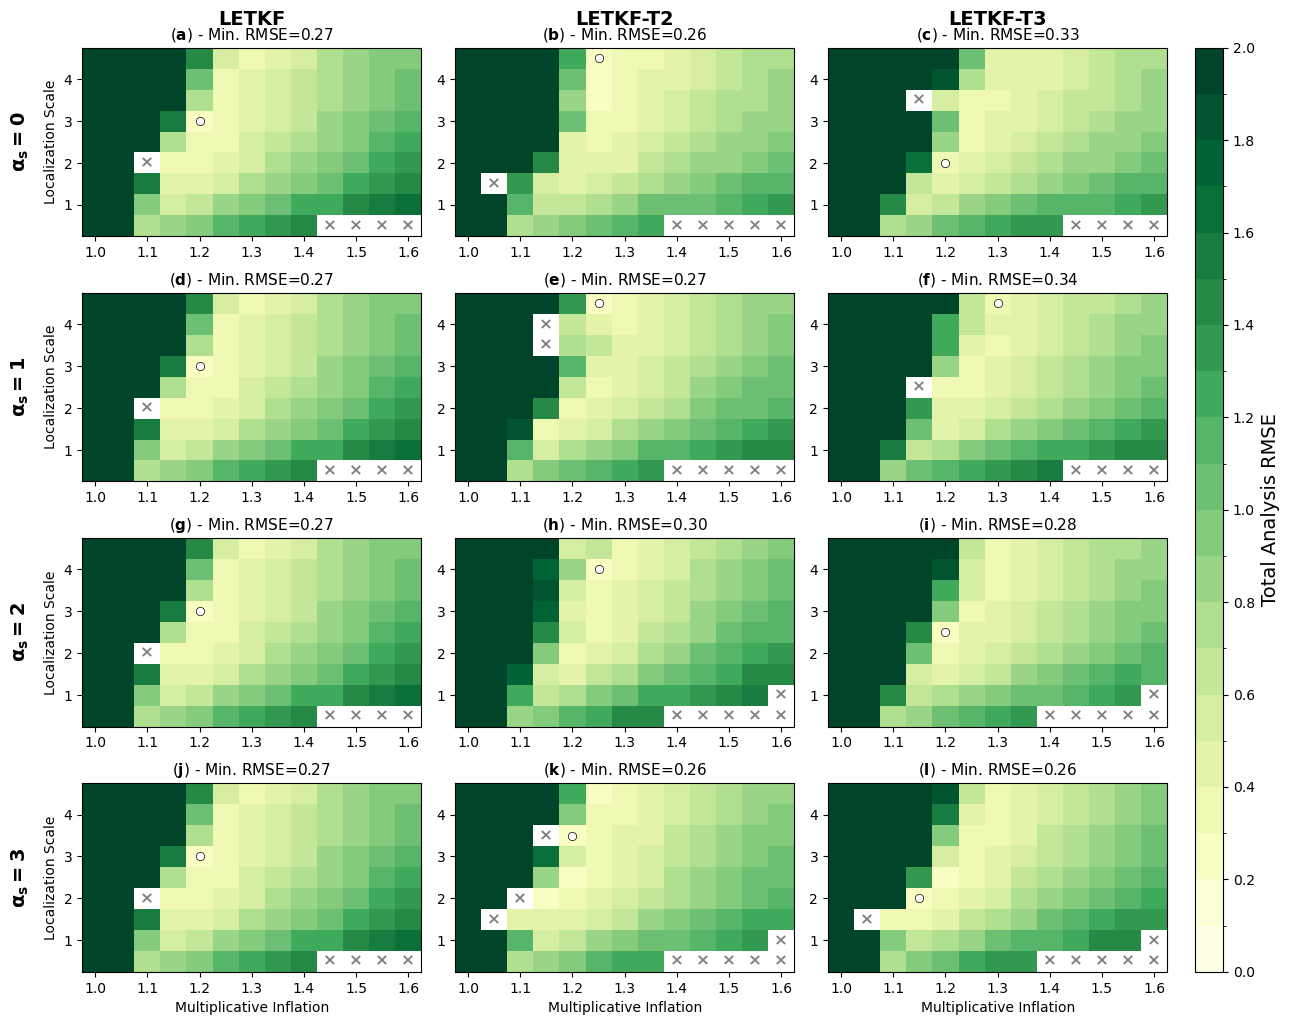

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import common_function as cf
import matplotlib.colors as mcolors
# Configuración


ntemps = [1, 2, 3]
labels = ['LETKF', 'LETKF-T2', 'LETKF-T3']
freq = 4
den = 1.0
alphas = [0,1,2,3]
nen = 80
ObseErr = '5'
gec = '_NOGEC'
fig, axes = plt.subplots(len(alphas), len(ntemps), figsize=(14, 12), 
                         sharex=False, sharey=False, 
                         gridspec_kw={'hspace': 0.3, 'wspace': 0.1})

cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])  # x, y, width, height
vmin, vmax = 0, 2
panel_label_counter = 0

for i, alpha in enumerate(alphas):
    for j, ntemp in enumerate(ntemps):
        # Load the data
        filename = f'LETKF_Paper_Nature_Freq{freq}_Den{den}_Type3_ObsErr{ObseErr}_Nens{nen}_NTemp{ntemp}_alpha{alpha}{gec}.npz'
        filepath = os.path.join(base_path, filename)
        #print(filepath)
        # Check if the file exists
        if os.path.exists(filepath):
            ax = axes[i, j]
            data = np.load(filepath, allow_pickle=True)
            mult_inf_range = data['mult_inf_range']
            loc_scale_range = data['loc_scale_range']
            total_analysis_rmse = data['total_analysis_rmse']

            NormalEnd = 1 - data['NormalEnd']
            NormalEnd = NormalEnd.astype(bool)
            total_analysis_rmse[NormalEnd] = np.nan
            total_analysis_rmse = cf.outlier_rmse_filter( total_analysis_rmse )

            min_rmse = np.nanmin(total_analysis_rmse)
            idx_min = np.where(total_analysis_rmse == min_rmse)
            best_mult_inf = mult_inf_range[idx_min[0][0]]
            best_loc_scale = loc_scale_range[idx_min[1][0]]

            total_analysis_rmse_smooth = smooth_filter(total_analysis_rmse, size=5)
            
            min_rmse_smooth = np.nanmin(total_analysis_rmse_smooth)
            idx_min_smooth = np.where(total_analysis_rmse_smooth == min_rmse_smooth)
            best_mult_inf_smooth = mult_inf_range[idx_min_smooth[0][0]]
            best_loc_scale_smooth = loc_scale_range[idx_min_smooth[1][0]]

            #im = ax.pcolormesh(mult_inf_range, loc_scale_range, total_analysis_rmse.T, 
            #                    vmin=vmin, vmax=vmax, cmap='PuBu',edgecolors='lightgray',linewidth=0.001)
            levels = np.arange(0, 2.1, 0.1)  # From 0 to 2, step 0.25
            norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

            im = ax.pcolormesh(mult_inf_range, loc_scale_range, total_analysis_rmse_smooth.T,
                            cmap='YlGn', norm=norm, edgecolors='lightgray', linewidth=0.001)            
            #ax.plot(best_mult_inf, best_loc_scale, 'k.', markersize=12, markeredgecolor='white',markeredgewidth=0.5)
            ax.plot(best_mult_inf_smooth, best_loc_scale_smooth, 'w.', markersize=12, markeredgecolor='black',markeredgewidth=0.5)
            
            nan_mask = np.isnan(total_analysis_rmse_smooth.T)
            for (y, x), is_nan in np.ndenumerate(nan_mask):
                if is_nan:
                    xi = mult_inf_range[x]
                    yi = loc_scale_range[y]
                    ax.text(xi, yi, '×', ha='center', va='center', color='gray', fontsize=12, fontweight='bold')

            panel_label = rf"$\bf{{{chr(97 + panel_label_counter)}}}$"
            ax.set_title(f"({panel_label}) - Min. RMSE={min_rmse_smooth:.2f}", fontsize=11)
            panel_label_counter += 1

            if j == 0:
                ax.set_ylabel('Localization Scale', fontsize=10)
            if i == len(alphas) - 1:
                ax.set_xlabel('Multiplicative Inflation', fontsize=10)

for i, alpha in enumerate(alphas):
    axes[i, 0].annotate(rf"$\bf{{\alpha_s = {alpha}}}$", xy=(-0.15, 0.5), xycoords='axes fraction',
                        rotation=90, va='center', ha='right', fontsize=14, weight='bold')
for j, t in enumerate(ntemps):
    axes[0, j].annotate(labels[j], xy=(0.5, 1.15), xycoords='axes fraction',
                        va='center', ha='center', fontsize=14, weight='bold')
cbar = fig.colorbar(im, cax=cbar_ax,ticks=np.arange(0, 2.2, 0.2))
cbar.set_label('Total Analysis RMSE', fontsize=14)

os.makedirs(output_dir, exist_ok=True)
figname = f"Figure_Alpha_Sensitivity_Freq{freq}_Den{den}_Type3_nens{nen}_ObsErr{ObseErr}{gec}_smooth"
output_pdf = os.path.join(output_dir, f"{figname}.pdf")
output_png = os.path.join(output_dir, f"{figname}.png")

plt.savefig(output_pdf, dpi=300, bbox_inches='tight', format='pdf')
plt.savefig(output_png, dpi=300, bbox_inches='tight', format='png')
#plt.show()

print(f"Figure saved as: \n PDF: {output_pdf} \n PNG: {output_png}")